In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!7z x /content/drive/MyDrive/Claheclasses_1.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 268015777 bytes (256 MiB)

Extracting archive: /content/drive/MyDrive/Claheclasses_1.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Claheclasses_1.zip
Type = zip
Physical Size = 268015777

  0%    
Would you like to replace the existing file:
  Path:     ./Claheclasses_1/1/99_left.jpeg
  Size:     19629 bytes (20 KiB)
  Modified: 2022-11-26 16:01:36
with the file from archive:
  Path:     Claheclasses_1/1/99_left.jpeg
  Size:     19629 bytes (20 KiB)
  Modified: 2022-11-26 16:01:36
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? s

  0% 2    

In [4]:
import pathlib
data_dir = '/content/Claheclasses_1'
data_dir = pathlib.Path(data_dir)

In [5]:
from pathlib import Path
import imghdr

In [6]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [11]:
batch_size = 32
img_height = 256
img_width = 256

In [12]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True, #to select random image
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [13]:
class_names = dataset.class_names
print(class_names)

['0', '1']


In [14]:
#training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.7,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3092 files for training.


In [15]:
#testing images
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [34]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

In [35]:
number_classes = len(class_names)

from keras.layers import  Dropout, BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

model = models.Sequential([
    data_augmentation,
        layers.Conv2D(32, (3,3), input_shape=(256,256,3), strides=(1, 1), activation='relu',padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(32, (3,3), activation='relu', strides=(1, 1), padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(32, activation='relu'),
        layers.Dense(number_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 75, 75, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)       

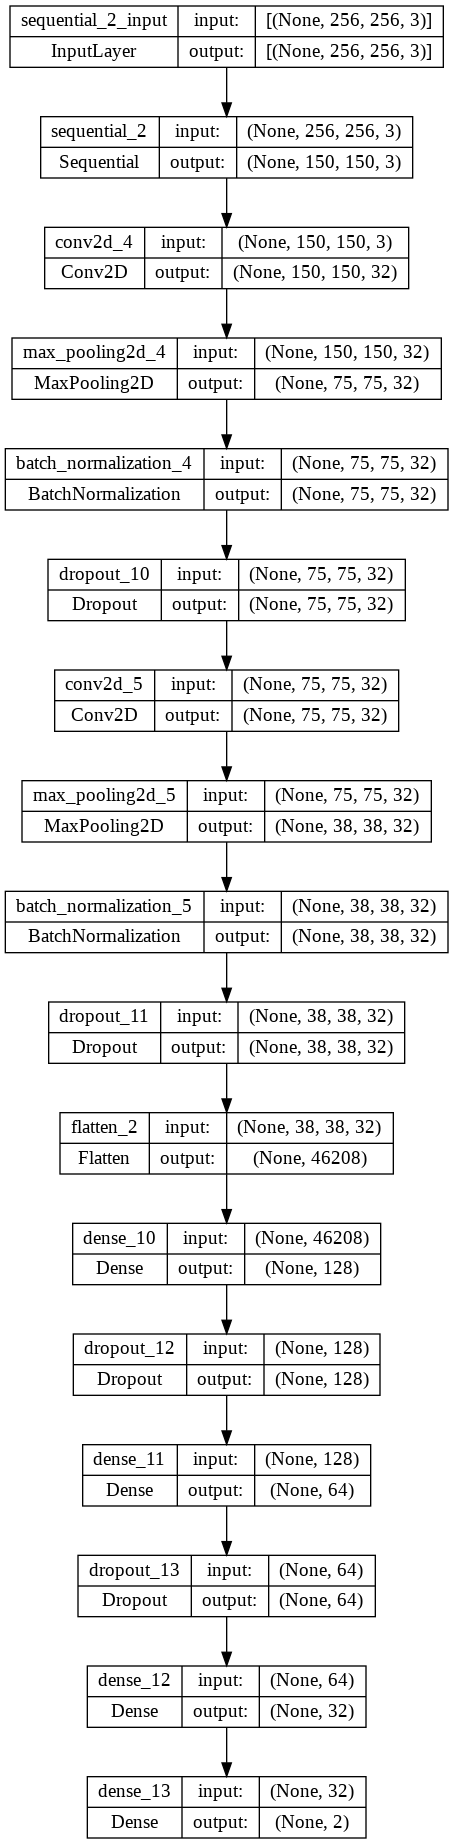

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [37]:
import time
start_cnn = time.time()

In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [87]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [88]:
#model compilation
model.compile(optimizer= opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list
)

Epoch 1/50
97/97 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4890
Epoch 1: val_accuracy improved from -inf to 0.49304, saving model to best_model.hdf5
97/97 [==============================] - 26s 242ms/step - loss: 0.6934 - accuracy: 0.4890 - val_loss: 0.6955 - val_accuracy: 0.4930
Epoch 2/50
97/97 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5036
Epoch 2: val_accuracy improved from 0.49304 to 0.49401, saving model to best_model.hdf5
97/97 [==============================] - 23s 240ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6962 - val_accuracy: 0.4940
Epoch 3/50
97/97 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5039
Epoch 3: val_accuracy improved from 0.49401 to 0.50081, saving model to best_model.hdf5
97/97 [==============================] - 23s 227ms/step - loss: 0.6955 - accuracy: 0.5039 - val_loss: 0.9547 - val_accuracy: 0.5008
Epoch 4/50
97/97 [==============================] - ETA: 0s -

In [90]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  2130.185621738434 seconds


In [91]:
scores = model.evaluate(train_ds)

97/97 [==============================] - 4s 35ms/step - loss: 0.6931 - accuracy: 0.5107


In [92]:
scores = model.evaluate(val_ds)

97/97 [==============================] - 4s 36ms/step - loss: 0.6937 - accuracy: 0.4966


Text(0.5, 1.0, 'Training and Validation Accuracy')

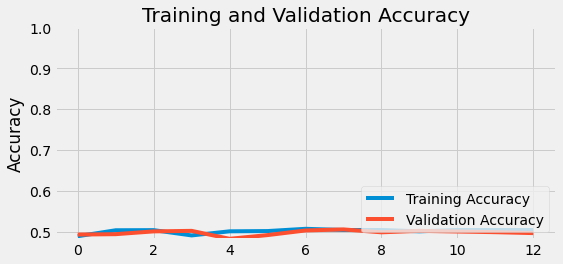

In [93]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


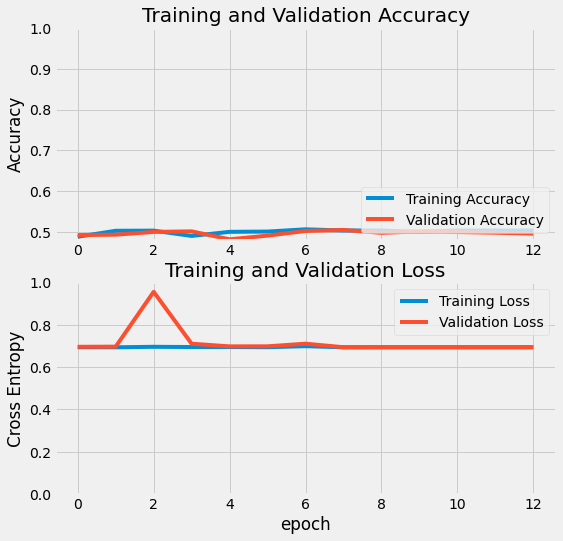

In [94]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [95]:
X = []
y = []
for image,labels in val_ds.take(100):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list) 

In [96]:
x = np.array(X)

In [97]:
y = np.array(y)

In [98]:
x.shape

(3091, 256, 256, 3)

In [99]:
y.shape

(3091,)

In [100]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3091])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3091], y_pred_classes))

97/97 [==============================] - 2s 16ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.54      0.05      0.09      1567
           1       0.49      0.96      0.65      1524

    accuracy                           0.50      3091
   macro avg       0.52      0.50      0.37      3091
weighted avg       0.52      0.50      0.37      3091



Text(0.5, 1.0, 'Training and Validation Accuracy')

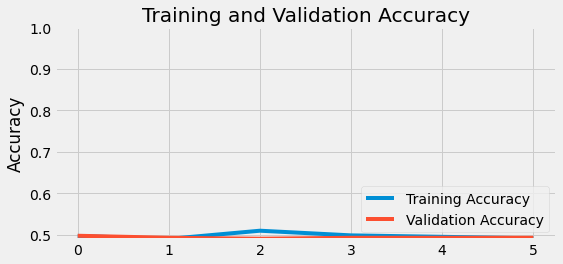

In [ ]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


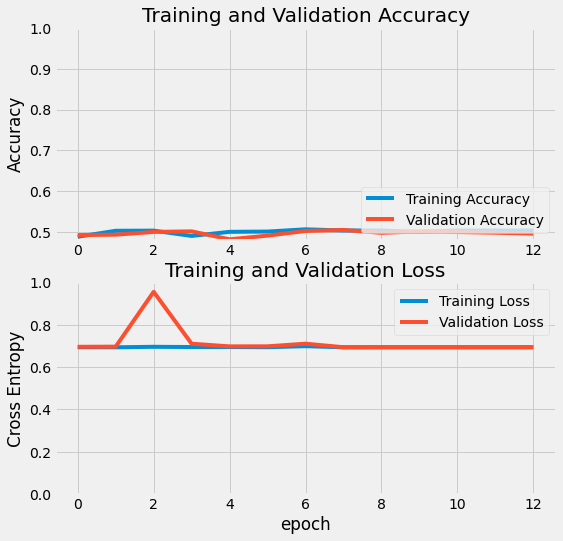

In [102]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

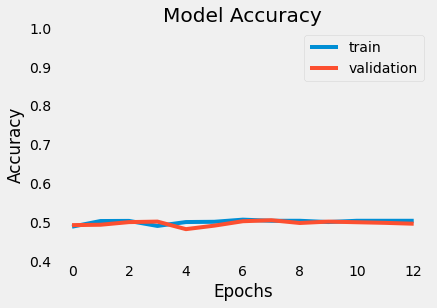

In [101]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()